# Retinal OCT Imaging
<hr style="border:2px solid pink">

## Introduction

#### Background

Retinal optical coherence tomography (OCT) is a noninvasive imaging technique that essentially takes pictures of your retinas by measuring how much light reflects off the retina and optic nerve. It can be used to diagnose and manage diseases like diabetes-related retinopathy and glaucoma, amongst others. Millions of OCT scans are performed each year, and the analysis and interpretation of the images can take up a tremendous amount of time.

#### Business Problem

In order to save time and resources in analyzing and interpreting OCT scans, the problem at hand is to create a model that can predict whether a patient's retinal scan is normal or shows signs of CNV, DME, or DRUSEN diseases. 

The stakeholders are medical professionals, specifically ophthalmologists.

#### Data Understanding

The data for this project comes from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/kermany2018/data. It
contains 84,495 images, and 4 categories to predict (NORMAL, CNV, DME, or DRUSEN). 

The data is split into separate train, test, and validation folders. Within each of these, there are labeled sub-folders for each category, with each individual image labeled as such: (disease)-(randomized patient ID)-(image number by
this patient).

The images were selected from adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017. 

#### Definitions

According to the [National Library of Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10411652/#:~:text=Age%2Drelated%20macular%20degeneration%20(AMD,tool%20for%20these%20ocular%20conditions.), the following terms are defined as follows: 

1. CNV: (Choroidal Neovascularization): a condition where abnormal blood vessels grow beneath the retina in the choroid area. These abnormal blood vessels can leak fluid or blood into the retina, which can cause vision loss. Commonly associated with age-related macular degeneration (AMD), which is a leading cause of vision loss in older adults.

2. DME (Diabetic Macular Edema): a complication of diabetic retinopathy, which is an eye condition that can develop in people with diabetes. DME occurs when fluid builds in the macula, the central part of the retina responsible for our central vision, leading to to vision impairment and distortion.

3. Drusen: small yellow or white deposits that accumulate in the retina. They can be found in the macula or the peripheral retina. Drusen are a hallmark sign of age-related macular degeneration (AMD). 

Treatment options for CNV, DME, and AMD may include medications, laser therapy, or in some cases, surgical interventions, depending on the specific condition and its stage.
<hr style="border:2px solid pink">

# General Exploration

To get started, let's import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.dummy import DummyClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate

from sklearn.metrics import confusion_matrix, classification_report,\
recall_score,accuracy_score, precision_score, f1_score, roc_auc_score

from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

Let's load in the data next. We need to create directories to where the data is saved, so let's start with that. 

In [2]:
# create directory paths for each folder (train, test, and val)
train_path = 'Data/OCT2017/train'
test_path = 'Data/OCT2017/test'
val_path = 'Data/OCT2017/val'

Let's get an idea of the size of the images, so that we know how we might rescale the images, and so we can check that every image is the same size. 

Loading in the data normally, no scaling or augmentations done, setting smaller batch sizes, and setting seed=42 to help with reproducibility. 

In [3]:
original_train = ImageDataGenerator().flow_from_directory(train_path, batch_size=200, seed=42)
original_test = ImageDataGenerator().flow_from_directory(test_path, batch_size=100, seed=42)
original_val = ImageDataGenerator().flow_from_directory(val_path, batch_size=5, seed=42)

original_train_images, original_train_labels = next(original_train)
original_test_images, original_test_labels = next(original_test)
original_val_images, original_val_labels = next(original_val)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


To find out the original size of the images, let's loop through every image in the images datasets, take the size of it, and add it to a list. 

In [4]:
# loop through each images in the array and add the size to an empty list

train_sizes = []
test_sizes = []
val_sizes = []

for img in original_train_images:
    size = np.array(array_to_img(img).size)
    train_sizes.append(size)
    
for img in original_test_images:
    size = np.array(array_to_img(img).size)
    test_sizes.append(size)
    
for img in original_val_images:
    size = np.array(array_to_img(img).size)
    val_sizes.append(size)

In [5]:
# how many unique sizes are in each list? theoretically should be the same for each pic
# change the list of np arrays into a list of tuples, then take the "set" to get unique values

unique_train_sizes = list(set([tuple(size) for size in train_sizes]))
unique_test_sizes = list(set([tuple(size) for size in test_sizes]))
unique_val_sizes = list(set([tuple(size) for size in val_sizes]))

print(f"Original Train Image Size: {unique_train_sizes}")
print(f"Original Test Image Size: {unique_test_sizes}")
print(f"Original Val Image Size: {unique_val_sizes}")

Original Train Image Size: [(256, 256)]
Original Test Image Size: [(256, 256)]
Original Val Image Size: [(256, 256)]


Great! So the original images were all 256x256. Notice when loading in the data that there are 4 classes; this represents normal, CNV, DME, or Drusen. Let's take a look at the distribution of the images in our dataset. 

In [6]:
# first, create paths to each individual folder
normal_train_path = 'Data/OCT2017/train/NORMAL'
cnv_train_path = 'Data/OCT2017/train/CNV'
dme_train_path = 'Data/OCT2017/train/DME'
drusen_train_path = 'Data/OCT2017/train/DRUSEN'

# then, take the "length" of each folder to get the total number of images per category
normal_count = len(os.listdir(normal_train_path))
cnv_count = len(os.listdir(cnv_train_path))
dme_count = len(os.listdir(dme_train_path))
drusen_count = len(os.listdir(drusen_train_path))

# print the results
print(f'Normal Count: {normal_count}')
print(f'CNV Count: {cnv_count}')
print(f'DME Count: {dme_count}')
print(f'Drusen Count: {drusen_count}')

Normal Count: 26315
CNV Count: 37205
DME Count: 11348
Drusen Count: 8616


So, there are 26,315 normal images, 37,205 CNV images, 11,348 DME images, and 8,616 Drusen images. Let's visualize the distribution. 

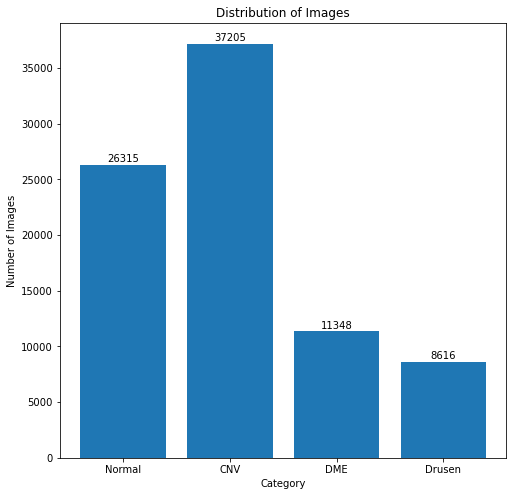

In [7]:
# create the categories for X (categories) and Y (counts)
categories = ['Normal', 'CNV', 'DME', 'Drusen']
counts = [normal_count, cnv_count, dme_count, drusen_count]

# plot it
fig, ax = plt.subplots(figsize=(8,8))
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images')

# add counts to the top of the bars
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show();

This makes the distributions a little more clear! There's the most CNV images and the least Drusen images. 

Let's look at a few images and labels, so we can get an idea of what we're dealing with. 

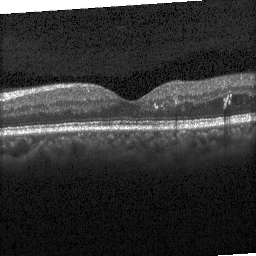

In [8]:
array_to_img(original_train_images[16])

In [9]:
original_train_labels[16]

array([0., 1., 0., 0.], dtype=float32)

In [10]:
original_train.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

Ok, so here, I see that each category corresponds to a class. CNV is class 0, DME is class 1, DRUSEN is class 2, and NORMAL is class 3. 

You would interpret the array [0., 1., 0., 0.] as follows: the first class (index 0, corresponds to CNV) has a probability of 0. The second class (index 1, corresponds to DME) has a probability of 1. The third class (index 2, corresponds to Drusen) and the fourth class (index 3, corresponds to normal) have probabilities of 0. This means that the image falls under class 1, and is DME. 

Let's see if we can plot a few images from each class at the same time, with their corresponding labels titling the plot.

In [ ]:
## add 2-3 images per category

## don't forget to look at the shapes of the dataset

recall v precision: recall prioritizes minimizing false negatives, precision minimizes false positives. We don't want to miss a potential diagnosis and call it normal, so we need to prioritize recall.

Then:
1. prep the data for modeling by normalizing and rescaling (mess around with a few resolutions)
2. baseline model
3. fsm
4. ssm, tsm, etc. until final
5. try gridsearching
6. fine tune activators, optimizers, how many units per layer, num of layers, etc.
7. print scores, plot loss/accuracy/recall, confusion matrix, roc curves. can do functions
8. use sequential models to start, look up other architectures
9. conclusion & next steps

Each session should have: 
1. create model, fit it, look at results, save both model and results
2. loss/accuracy/recall plots, confusion matrices, roc curves
3. explanation of metrics, work out next model, etc.
4. maybe at the end can add a ranking
5. maybe print out some of the predicted labels for an image, inspect it visually